# The Pandemic's Effect on Trends in Music: Exploration

Authors: Natnael Mekonnen, Sonya Lew, and Daniel Park

## Introduction

last semester in spring 2019 we were in a pandemic with covid-19. We were all forced to social distance, quartine, and take our academic classes online. we know that everyone has been suffering from this pandemic with a lack of face to face interaction and degrading mental health. And since everyone is a fan of music we were wondering if there is a connection to how this pandemic can affect what songs are being listened to and their traits? we will be using Spotify API, Spotify’s tops 200 songs weekly in the US CSV files for 2 years, and a dataset that we found online. we'll be using all of this to find a correlation on how the pandemic has affected what music we listen to or how its affected the top 200 songs on Spotify since the start of the pandemic.

Why did we choose this topic? What is the importance?
Do we anticipate to be any changes? 

## Getting Started

## 1. Data Scraping

To explore the pandemic's effect on music, we chose to compare the COVID data in the US with the top 20 list on Spotify since January 2020. The COVID data will be extracted from the Atlantic's [The COVID Tracking Project](https://covidtracking.com/data/national) which has been constantly updating the data everyday with representatives from 50 states, 5 territories, and District of Colombia. On the other hand, the Spotify top 20 will be extracted from the [Spotify Charts](https://spotifycharts.com/) on a weekly starting from January 2020. The charts does not have a detail information on the song so we will get more detail by querying the Spotify API.  

Import the necessary libraries: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## 1.1 Load and View COVID data

In [ ]:
covid_data = pd.read_csv('national-history.csv')
covid_data.head()

The COVID data is detailed but since this project is finding its relationship with music, most of the unnecessary columns will be dropped.

In [ ]:
if 'death' in covid_data.columns:
    covid_data = covid_data.drop(['death','deathIncrease','inIcuCumulative','inIcuCurrently', 'hospitalizedIncrease','hospitalizedCurrently','hospitalizedCumulative','onVentilatorCumulative','onVentilatorCurrently','recovered','states'], axis=1)


Knowing that the Spotify data is grouped on a weekly basis starting on a Friday, the next step is to prepare the COVID data so it is easy to merge.

In [ ]:
# Creating a custom interval index for grouping the data which starts from begining of the year on a Friday and continues weekly
i = pd.to_datetime('01/10/2020')
bins = []
while i < pd.to_datetime('12/04/2020'):
    temp = i + pd.Timedelta('7 days')
    bins.append((i,temp))
    i = temp
bins = pd.IntervalIndex.from_tuples(bins)

In [ ]:
# Convert the date from the dataframe to a pandas date and time format to be comuted in the cutting
covid_data['date'] = pd.to_datetime(covid_data['date'])

# Using the interval index created above, create a new column week which has the week interval of the data
covid_data['week'] = pd.cut(covid_data['date'], bins)

# Now that every row has a week interval, they will be grouped with the total for each column 
grouped_covid = covid_data.groupby(['week']).sum()

# Number the weeks to easily identify
grouped_covid['week_num'] = list(range(1,len(bins)+1))

grouped_covid.head(10)

In [ ]:
column_names = ['week_num','positiveIncrease','negativeIncrease','positive','negative','totalTestResultsIncrease','totalTestResults']
grouped_covid = grouped_covid.reindex(columns=column_names)

grouped_covid.head(10)

In [ ]:
## 1.2 Load and View Spotify Top 20 Weekly Data

As mentioned above, the weekly Spotify top 10 list for 2020 has been downloaded as a csv file. However, since the data is not robust, the Spotify developer API was used to get more detail information on the songs and collectively stored under `data.csv`. The script to run this process is under `spotify_data_extraction.py`.

In [ ]:
spotify_data = pd.read_csv('data10.csv')
spotify_data.head()

In [ ]:
spotify_data['start_date']  = pd.to_datetime(spotify_data['start_date'])

# Using the same interval index created for the covid_data, create a new column week which has the week interval
spotify_data['week'] = pd.cut(spotify_data['start_date'], bins)

# Now that week is included, we can reindex with only the columns we need
spotify_data = spotify_data.reindex(columns=['week','length', 'popularity',
       'danceability', 'acousticness', 'danceability.1', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'time_signature'])

spotify_data.head()

In [ ]:
# Now that every row has a week interval, they will be grouped with the mean for each column. The following table will contain
# Spotify data during the pandemic 
grouped_spotify = spotify_data.groupby(['week']).mean()
grouped_spotify.head()

Now we'll create a table for pre-COVID Spotify data to see how trends compare before and after the first COVID tests were administered


In [ ]:
pre_spotify = pd.read_csv('pre_data.csv')
pre_spotify.sort_values(by=['start_date'], inplace=True)
# pre_spotify

In [ ]:

# We want to analyze Spotify data from January 2019 to January 2020 to compare to Spotify data when the first tests were administered
i = pd.to_datetime('01/04/2019')
pre_bins = []
while i < pd.to_datetime('01/03/2020'):
    temp = i + pd.Timedelta('7 days')
    pre_bins.append((i,temp))
    i = temp
pre_bins = pd.IntervalIndex.from_tuples(pre_bins)



In [ ]:
pre_spotify['start_date'] = pd.to_datetime(pre_spotify['start_date'])

# Using the interval index created above, create a new column week which has the week interval of the data
pre_spotify['week'] = pd.cut(pre_spotify['start_date'], pre_bins)

# Now that every row has a week interval, they will be grouped with the total for each column 
grouped_pre = pre_spotify.groupby(['week']).sum()

# Number the weeks to easily identify
grouped_pre['week_num'] = list(range(1,len(pre_bins)+1))


In [ ]:
# Reindex with only the columns we need
pre_spotify = grouped_pre

pre_spotify = pre_spotify.reindex(columns=['week_num','length', 'popularity',
       'danceability', 'acousticness', 'danceability.1', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'time_signature'])

pre_spotify = pre_spotify.groupby(['week_num']).mean()
pre_spotify.head()

## 1.3 Merge the Spotify and Covid Data

In [ ]:
merged = grouped_covid.merge(grouped_spotify, left_on='week', right_on='week')
merged.head()

## 2. Data Analysis and Visualization

In [ ]:
# In order to graph some variables from covid with spotify, they have to get normalized. In this case min-max normalization is used on negative increase
merged['norm_positive_i'] = (merged.positiveIncrease-merged.positiveIncrease.min())/(merged.positiveIncrease.max()-merged.positiveIncrease.min())

merged['norm_length'] = (merged.length-merged.length.min())/(merged.length.max()-merged.length.min())

merged['norm_tempo'] = (merged.tempo-merged.tempo.min())/(merged.tempo.max()-merged.tempo.min())
merged = merged[:48]

Slope of trend in positive COVID cases: 0.014494904676598797
Slope of trend in energy of top songs: nan
Slope of trend in danceability of top songs: nan
Slope of trend in instrumentalness of top songs: nan


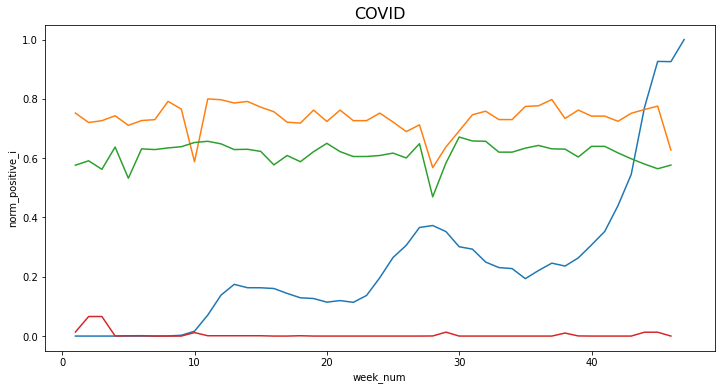

In [505]:
plt.figure(figsize=(12,6))
plt.title("COVID", fontsize=16)
sns.lineplot(data=merged, x='week_num', y='norm_positive_i')
sns.lineplot(data=merged, x='week_num', y='danceability') 
sns.lineplot(data=merged, x='week_num', y='energy')
sns.lineplot(data=merged, x='week_num', y='instrumentalness')


x = range(0, len(merged.week_num))
cases_reg = np.polyfit(x, merged.norm_positive_i, 1)
cases_line = np.poly1d(cases_reg)

x = range(0, len(merged.week_num))
energy_reg = np.polyfit(x, merged.energy, 1)
energy_line = np.poly1d(energy_reg)

x = range(0, len(merged.week_num))
dance_reg = np.polyfit(x, merged.danceability, 1)
dance_line = np.poly1d(dance_reg)

x = range(0, len(merged.week_num))
instr_reg = np.polyfit(x, merged.instrumentalness, 1)
instr_line = np.poly1d(instr_reg)
# plt.plot(merged.week_num, b(x), c="r", ls=':')

print(f'Slope of trend in positive COVID cases: {cases_line.c[0]}')
print(f'Slope of trend in energy of top songs: {energy_line.c[0]}')
print(f'Slope of trend in danceability of top songs: {dance_line.c[0]}')
print(f'Slope of trend in instrumentalness of top songs: {instr_line.c[0]}')

###  note for analysis: Possibility that energy and # of positive cases increases bc more ppl are going out and partying which causes cases to increase in the first place ??


# print(merged.week_num)
# sns.lineplot(data=merged, x='week#', y='tempo')
# sns.lineplot(data=merged, x='week#', y='liveness')
# sns.lineplot(data=merged, x='week#', y='norm_tempo')
plt.show()

## Pre-COVID vs. During COVID

<AxesSubplot:xlabel='week_num', ylabel='danceability'>

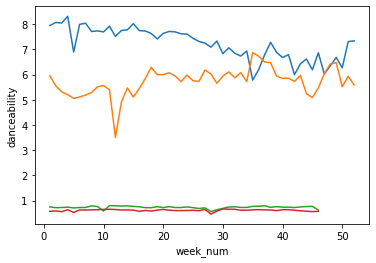

In [514]:
# How do the trends in top Spotify songs sompare to trends pre-COVID?

sns.lineplot(data=pre_spotify, x='week_num', y='danceability') 
sns.lineplot(data=pre_spotify, x='week_num', y='energy')
# sns.lineplot(data=pre_spotify, x='week_num', y='instrumentalness')
sns.lineplot(data=merged, x='week_num', y='danceability') 
sns.lineplot(data=merged, x='week_num', y='energy')
# sns.lineplot(data=merged, x='week_num', y='instrumentalness')

# Pre-COVID significantly higher danceability and energy
# Speaks to what artists are writing/producing as well as what ppl are listening to


In [ ]:
merged